# Part 1 - The most common continuous model - the Gaussian 

Welcome back! Today, we will now focus on how to incorporate continuous variables in your graphical model, and on how to estimate the parameters (e.g. to generate predictions later)

As usual, we'll start with the imports. 

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from math import log
%matplotlib inline

One thing we will do a lot in this course, is create some "toy data". The idea is to have datasets that we know so well, that we even know the true parameters. It is important for you to understand how well your PGM is able to learn them!

...of course, in the real world, you don't know the true parameters. That's what makes it hard and interesting!



In [5]:
mu_true=7         #True parameters. Feel free to mess around with them... 
sigma_true=100
X=np.random.normal(mu_true,sigma_true,1000)   #generate 1000 samples from this gaussian 

It is always useful to plot the distribution, whenever it's possible...

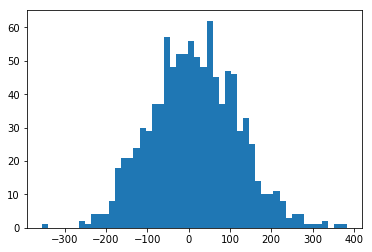

In [6]:
plt.hist(X, bins=50);

## 1.1 Maximum Log Likelihood

So, we're ready to start...

In the last lecture, you played with the log likelihood function:

$ln\text{ }L(\mu, \sigma^2)=-\frac{n}{2}ln(2\pi)-\frac{n}{2}ln(\sigma^2)-\frac{1}{2\sigma^2}\sum_i^N (x_i-\mu)^2$

We still assume that the standard deviation, $\sigma$ is given. The  program below finds the (approximate) maximum log likelihood estimate for the mean ($\mu$)

In [7]:
def Gaussian_loglikelihood(X, mu, sigma):
    n=len(X)
    return -n/2*log(2*np.pi)-n/2*log(sigma**2)-1/(2*sigma**2)*sum([(x-mu)**2 for x in X])

def MLE(X, sigma):
    l=[]
    maxll=-9999999
    bestmu=-9999999
    mus=np.arange(-100, 100, 0.01)
    for mu in mus:
        ll=Gaussian_loglikelihood(X, mu, sigma)
        l.append(ll)
        if ll>maxll:
            bestmu=mu
            maxll=ll
    return bestmu, mus, l
        

Please test your program (e.g. choose $\sigma=5$)

## 1.2. Bayesian model

In this case, the difference in our model is that we also have priors. Since we're only estimating $\mu$, we only need to add that prior. Let's assume it is:

$\mu \sim \mathcal{N}(\alpha, \gamma)$

Our log probability formula then becomes:

$ln\text{ }L(\mu, \sigma, \alpha, \gamma)=-\frac{n}{2}ln(2\pi)-\frac{n}{2}ln(\sigma^2)-\frac{1}{2\sigma^2}\sum_i^N (x_i-\mu)^2-\frac{ln(2\pi)}{2}-\frac{ln(\gamma^2)}{2}-\frac{(\alpha-\mu)^2}{2\gamma^2}$


Essentially, we only added the last three terms to the earlier formula. Can you estimate now the value for $\mu$ (you can reuse the function given above if you want)?

In [8]:
SUBSET=10   #for comparison when we vary number of data points 
sigma=100
mlemu, mus, llist=MLE(X[:SUBSET], sigma)


In [9]:
def log_mu_prior(mu, alpha, gamma):
    return -1/2*log(2*np.pi)-1/2*log(gamma**2)-1/(2*gamma**2)*(alpha-mu)**2

def log_posterior_mu(X, sigma, alpha, gamma):
    lposterior=[]
    MAPll=-9999999
    MAP=-9999999
    mus=np.arange(-100, 100, 0.01)
    for mu in mus:
        ll=Gaussian_loglikelihood(X, mu, sigma)+log_mu_prior(mu, alpha, gamma)
        lposterior.append(ll)
        if ll>MAPll:
            MAP=mu
            MAPll=ll
    return MAP, mus, lposterior
        

Can you visualize the log probability, as a function $\mu$?

-10.47


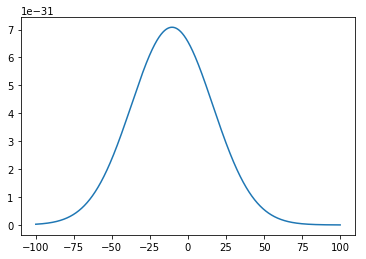

In [10]:
alpha=0
gamma=50
postmu, mus, llist=log_posterior_mu(X[:SUBSET], sigma, alpha, gamma)
print(postmu)
plt.plot(mus, np.exp(llist));

Hmmm... the value is not that different, indeed. Why didn't the Bayesian model work better? To answer this, try varying the number of datapoints. The lower it is, the more important your prior becomes!

Challenge to take home: make it an online learning process (you can even make it a movie! :-) )... 

# Part 2 - Generative story

Consider the "dwell time prediction" story we discussed in the lecture.

Implement a function that generates the data according to the slides. 

We write the first and last lines of your code... ;-) 



In [11]:
def dwell_time(X, N, sigmab, sigmae, pi):
    dtn=[]
    
    beta=np.random.multivariate_normal([10, 0], np.eye(2)*sigmab)
    for n in range(1, N):
        zn=np.random.binomial(1, pi)
        kn=np.random.normal(beta[0]+beta[1]*X[n], sigmae)
        if zn==0:
            dtn.append(0)
        else:
            dtn.append(kn)
    return dtn #returns the list of generated data through ancestral sampling

Let's create the X dataset then

In [12]:
N=1000
X=np.random.binomial(1, .4, size=N) #there's less occurences of peak hour buses (just because it's less time in the day)

Run your function to generate N points (i.e. perform _ancestral sampling_). Choose whatever parameters you like

In [13]:
dtn=dwell_time(X, N, 5, 1, 0.8)

Enjoy the plots...

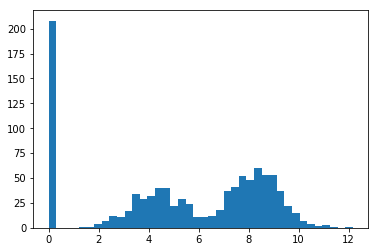

In [14]:
plt.hist(dtn,  bins=40);

# Part 3 - Gaussian mixture

Let's play with mixture models? :-)

We will start with some data generation again

In [15]:
mu1_true=-3
mu2_true=13
sigma1_true=5
sigma2_true=5

X1=np.random.normal(mu1_true,sigma1_true,90)  #We start with a small number of points
X2=np.random.normal(mu2_true,sigma2_true,50) # you'll understand later why... ;-)



We can also visualize it

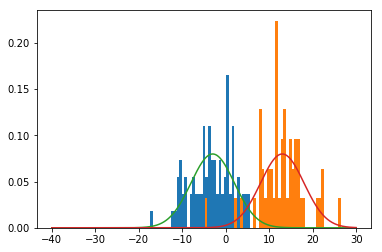

In [16]:
from scipy.stats import norm, dirichlet

plt.hist(X1, bins=50, normed=True)
plt.hist(X2, bins=50, normed=True)
x=np.arange(-40,30, 0.01)
y1=norm.pdf(x, mu1_true, sigma1_true)
y2=norm.pdf(x, mu2_true, sigma2_true)
plt.plot(x, y1)
plt.plot(x, y2);

we need to put everything in the same dataset... tough reality calling!

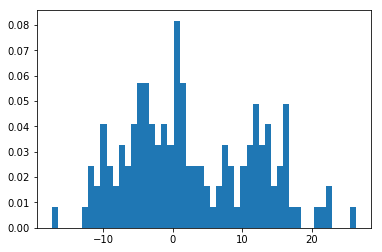

In [20]:
X=np.append(X1, X2)

plt.hist(X, bins=50, normed=True);

Looks ugly!...

It's time for you to implement the model and infer the parameters... 

Let's simplify a bit from the slides. Let's assume we actually know the true variances of the two gaussians (as defined above), so we don't need to consider $\boldsymbol{\Psi}$ and $\nu$. In that case, our log probability looks like:

$ln(P(\pi, \mu|\sigma, \sigma_{\mu}, \alpha))=\sum_1^n \big[ln(\mathcal{N}(x_n|\mu_1, \sigma) \pi + \mathcal{N}(x_n|\mu_2, \sigma) (1-\pi))+ln(Dir(\pi|\alpha))+ln(\mathcal{N}(\mu_1|0, \sigma_{\mu}))+ln(\mathcal{N}(\mu_2|0, \sigma_{\mu}))\big]$


Can you implement this function and estimate the right parameters for $\mu_1$, $\mu_2$ and $\pi$?

For now, just worry about finding the **maximum** value of the distribution (also called the "posterior distribution"), as opposed to the full distribution for each parameter. This is called the "Maximum A Posteriori" estimate, or MAP. 

(how would you get the posterior distribution of each parameter?)

In [21]:
K=2

def mix_ll(X, theta1, theta2, pi):
    mu1, sigma1=theta1
    mu2, sigma2=theta2
    return sum([ log(norm.pdf(x, mu1, sigma1)*pi+norm.pdf(x, mu2, sigma2)*(1-pi)) for x in X])

def ll_pi(pi, alpha):
    non_pi=1-pi
    return dirichlet.logpdf(np.array([pi, non_pi]), alpha)

def ll_mu(mu, loc, sigma):
    return norm.logpdf(mu, loc, sigma)

def mix_MAP(X, alpha, sigmak):
    sigma1=5
    sigma2=5
    pi_range=np.arange(0.1,0.9,0.1)
    mu_range=np.arange(-15, 15, 1)
    sigma_range=np.arange(3, 11, 1)
    lposterior=[]
    MAPll=-9999999
    MAP=-9999999
    for pi in pi_range:
        for mu1 in mu_range:
            for mu2 in mu_range:
                ll=mix_ll(X, [mu1, sigma1], [mu2, sigma2], pi)+ll_pi(pi, alpha)+ll_mu(mu1, 0, sigmak)+ll_mu(mu2, 0, sigmak)
                if ll>MAPll:
                    MAPll=ll
                    MAP= ([mu1, sigma1], [mu2, sigma2], pi)
    
    return MAP, MAPll
                        
    

In [22]:
MAP=mix_MAP(X, np.array([1,1]), 50)

In [23]:
([mu1, sigma1], [mu2, sigma2], pi),_=MAP

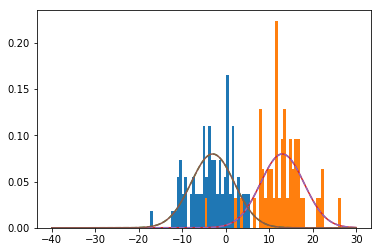

In [24]:

plt.hist(X1, bins=50, normed=True)
plt.hist(X2, bins=50, normed=True)
x=np.arange(-40,30, 0.01)
y1=norm.pdf(x, mu1_true, sigma1_true)
y1est=norm.pdf(x, mu1, sigma1)
y2=norm.pdf(x, mu2_true, sigma2)
y2est=norm.pdf(x, mu2, sigma2)
plt.plot(x, y1,  ls='--')
plt.plot(x, y1est)
plt.plot(x, y2,  ls='--')
plt.plot(x, y2est);
